## Setup

In [ ]:
!git clone https://github.com/sithu31296/semantic-segmentation
%cd image-classification
%pip install -r requirements.txt

In [1]:
import torch
import random
from torchvision import io
from torchvision import transforms as T
from PIL import Image

def show_image(image):
    if image.shape[2] != 3: image = image.permute(1, 2, 0)
    image = Image.fromarray(image.numpy())
    return image

## Show Available Pretrained Models

In [1]:
from utils.utils import show_models

show_models()

Model Names    Model Variants
-------------  ------------------------------------
segformer      ['B0', 'B1', 'B2', 'B3', 'B4', 'B5']
ddrnet         ['23slim', '23']


## Load a Pretrained Model

Download a pretrained model's weights from the result table (ADE20K, CityScapes, ...) and put it in `checkpoints/pretrained/model_name/`.

In [2]:
from models import get_model

model = get_model(
    model_name='segformer',
    variant='B3',
    num_classes=150     # ade20k
)
model.load_state_dict(torch.load('checkpoints/pretrained/segformer/segformer.b3.ade.pth', map_location='cpu'))
model.eval()

print('Loaded Model')

Loaded Model


## Simple Image Inference

### Load Image

torch.Size([3, 512, 683])


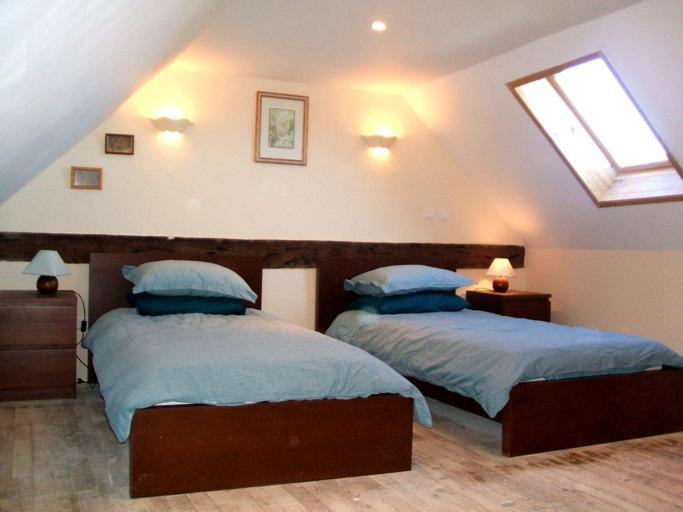

In [3]:
image_path = 'assests/ade/ADE_val_00000049.jpg'
image = io.read_image(image_path)
print(image.shape)
show_image(image)

### Preprocess

In [4]:
# resize
image = T.CenterCrop((512, 512))(image)
# scale to [0.0, 1.0]
image = image.float() / 255
# normalize
image = T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(image)
# add batch size
image = image.unsqueeze(0)
image.shape

torch.Size([1, 3, 512, 512])

### Model Forward

In [5]:
with torch.no_grad():
    seg = model(image)
seg.shape

torch.Size([1, 150, 512, 512])

### Postprocess

In [6]:
seg = seg.softmax(1).argmax(1).to(int)
seg.unique()

tensor([  0,   3,   5,   7,   8,  15,  22,  36,  57,  82, 134])

In [11]:
from datasets import ADE20K

palette = ADE20K.PALETTE

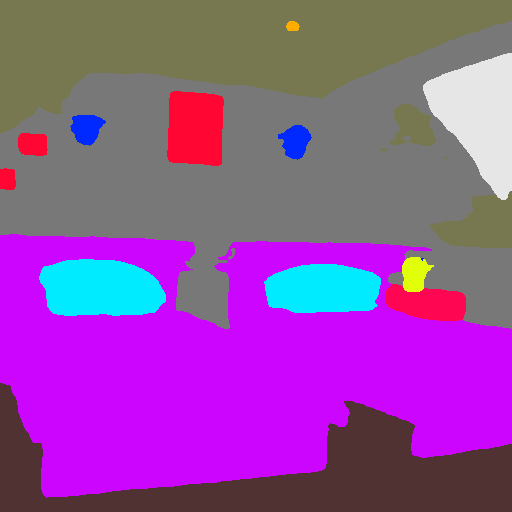

In [12]:
seg_map = palette[seg].squeeze().to(torch.uint8)
show_image(seg_map)

## Show Available Backbones

In [13]:
from models import backbones

backbones.__all__

['ResNet', 'MiT', 'CycleMLP', 'PVTv2', 'ResT']

## Show Available Heads

In [14]:
from models import heads

heads.__all__

['UPerHead', 'SegFormerHead']

## Construct a Custom Model

### Choose a Backbone

In [15]:
from models.backbones import ResNet

backbone = ResNet('18')

In [20]:
# init random input batch
x = torch.randn(2, 3, 224, 224)

In [21]:
# get features from the backbone
features = backbone(x)
for out in features:
    print(out.shape)

torch.Size([2, 64, 56, 56])
torch.Size([2, 128, 28, 28])
torch.Size([2, 256, 14, 14])
torch.Size([2, 512, 7, 7])


### Choose a Head

In [22]:
from models.heads import UPerHead

head = UPerHead([64, 128, 256, 512], 128, num_classes=10)

In [23]:
seg = head(features)
seg.shape

torch.Size([2, 10, 56, 56])

In [24]:
from torch.nn import functional as F
# upsample the output
seg = F.interpolate(seg, size=x.shape[-2:], mode='bilinear', align_corners=False)
seg.shape

torch.Size([2, 10, 224, 224])

Check `models/custom_cnn.py` and `models/custom_vit.py` for a complete construction for custom model.